# University of Stavanger
## ELE510 - Computer vision and image processing final project.
Image denoising of multiplicative speckle noise

## Authors
* Asahi Cantu
* Ali Akbar

## Extracting image sources from knwon web hosts

In [ ]:
% pip install tqdm
% pip install numpy
% pip install matplotlib
% pip install opencv-python
% pip install sklearn
% pip install findpeaks

UsageError: Line magic function `%` not found.


In [8]:
import sys
import os
import urllib
import zipfile
from tqdm import notebook
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

img_dir = 'img'
img_urls=[
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH01_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH02_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH03_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH04_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH05_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH06_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH07_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH08_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH08_Original_Video_Clips.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH09_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH10_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH11_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH12_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_Problem_Figures.zip"
]

In [ ]:
for i, img_url in enumerate(img_urls):
    file_name = os.path.join(img_dir,img_url.split('/')[-1])
    print(f'Downloading {i+1} from {len(img_urls)} {img_url} into {file_name}...')
    urllib.request.urlretrieve(img_url, file_name)
    print(f'Decompressing {file_name}....')
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_files = [f for f in zip_ref.filelist if '.tif' in f.filename]
        for j, zip_file in enumerate(zip_files):
            zip_file.filename = os.path.basename(zip_file.filename)
            print(f'\t Extracting {j+1} of {len(zip_files)} {zip_file.filename}...')
            zip_ref.extract(zip_file, img_dir)
    os.remove(file_name)

Decompressing img\DIP3E_CH01_Original_Images.zip....
	 Extracting 1 of 62 Fig0101(1921 digital image).tif...
	 Extracting 2 of 62 Fig0102(1922 digital image).tif...
	 Extracting 3 of 62 Fig0103(1929 digital image Pershing and Foch).tif...
	 Extracting 4 of 62 Fig0104(Ranger7_1st picture_of_moon).tif...
	 Extracting 5 of 62 Fig0106(a)(bone-scan-GE).tif...
	 Extracting 6 of 62 Fig0106(b)(PET_image).tif...
	 Extracting 7 of 62 Fig0106(c)(cygnusloop-gamma).tif...
	 Extracting 8 of 62 Fig0106(d)(gamma-Wehe-enhanced).tif...
	 Extracting 9 of 62 Fig0107(a)(chest-xray-vandy).tif...
	 Extracting 10 of 62 Fig0107(b)(kidney-original).tif...
	 Extracting 11 of 62 Fig0107(c)(headCT-Vandy).tif...
	 Extracting 12 of 62 Fig0107(d)(Cktboard-Lixi).tif...
	 Extracting 13 of 62 Fig0107(e)(cygnusloop-Xray).tif...
	 Extracting 14 of 62 Fig0108(a) (corn-fluorescence).tif...
	 Extracting 15 of 62 Fig0108(b) (smutcorn-fluorescence).tif...
	 Extracting 16 of 62 Fig0108(c)(cygnusloop-extreme ultraviolet).tif...


## Selecting suitable image case studies

In [9]:
img_cases = [
    'Fig0221(a)(ctskull-256).tif',
    'Fig0222(a)(face).tif',
    'Fig0222(b)(cameraman).tif',
    'Fig0507(a)(ckt-board-orig).tif',
    'Fig0519(a)(florida_satellite_original).tif',
    'Fig1138(d)(WashingtonDC_Band4_564).tif',
    'FigP0421(right)(center-padded_image).tif',
    'FigP0436(a).tif',
    'Fig0726(a).tif',
    'Fig0117(a)(MRI-of-knee-Univ-Mich).tif',
    'Fig0116(Radar_Tibet_Mountains-highres).tif'
    ]

## Creatinig random spekle noise in candidate casses

In [10]:
def set_subplot_settings(img, ax, title):
    ax.imshow(img, cmap='gray', vmin=0, vmax=255)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

In [15]:
%pip install findpeaks

Note: you may need to restart the kernel to use updated packages.


C:\Python310\lib\site-packages\scipy\stats\stats.py:1021: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis, ddof=ddof) / a.mean(axis)


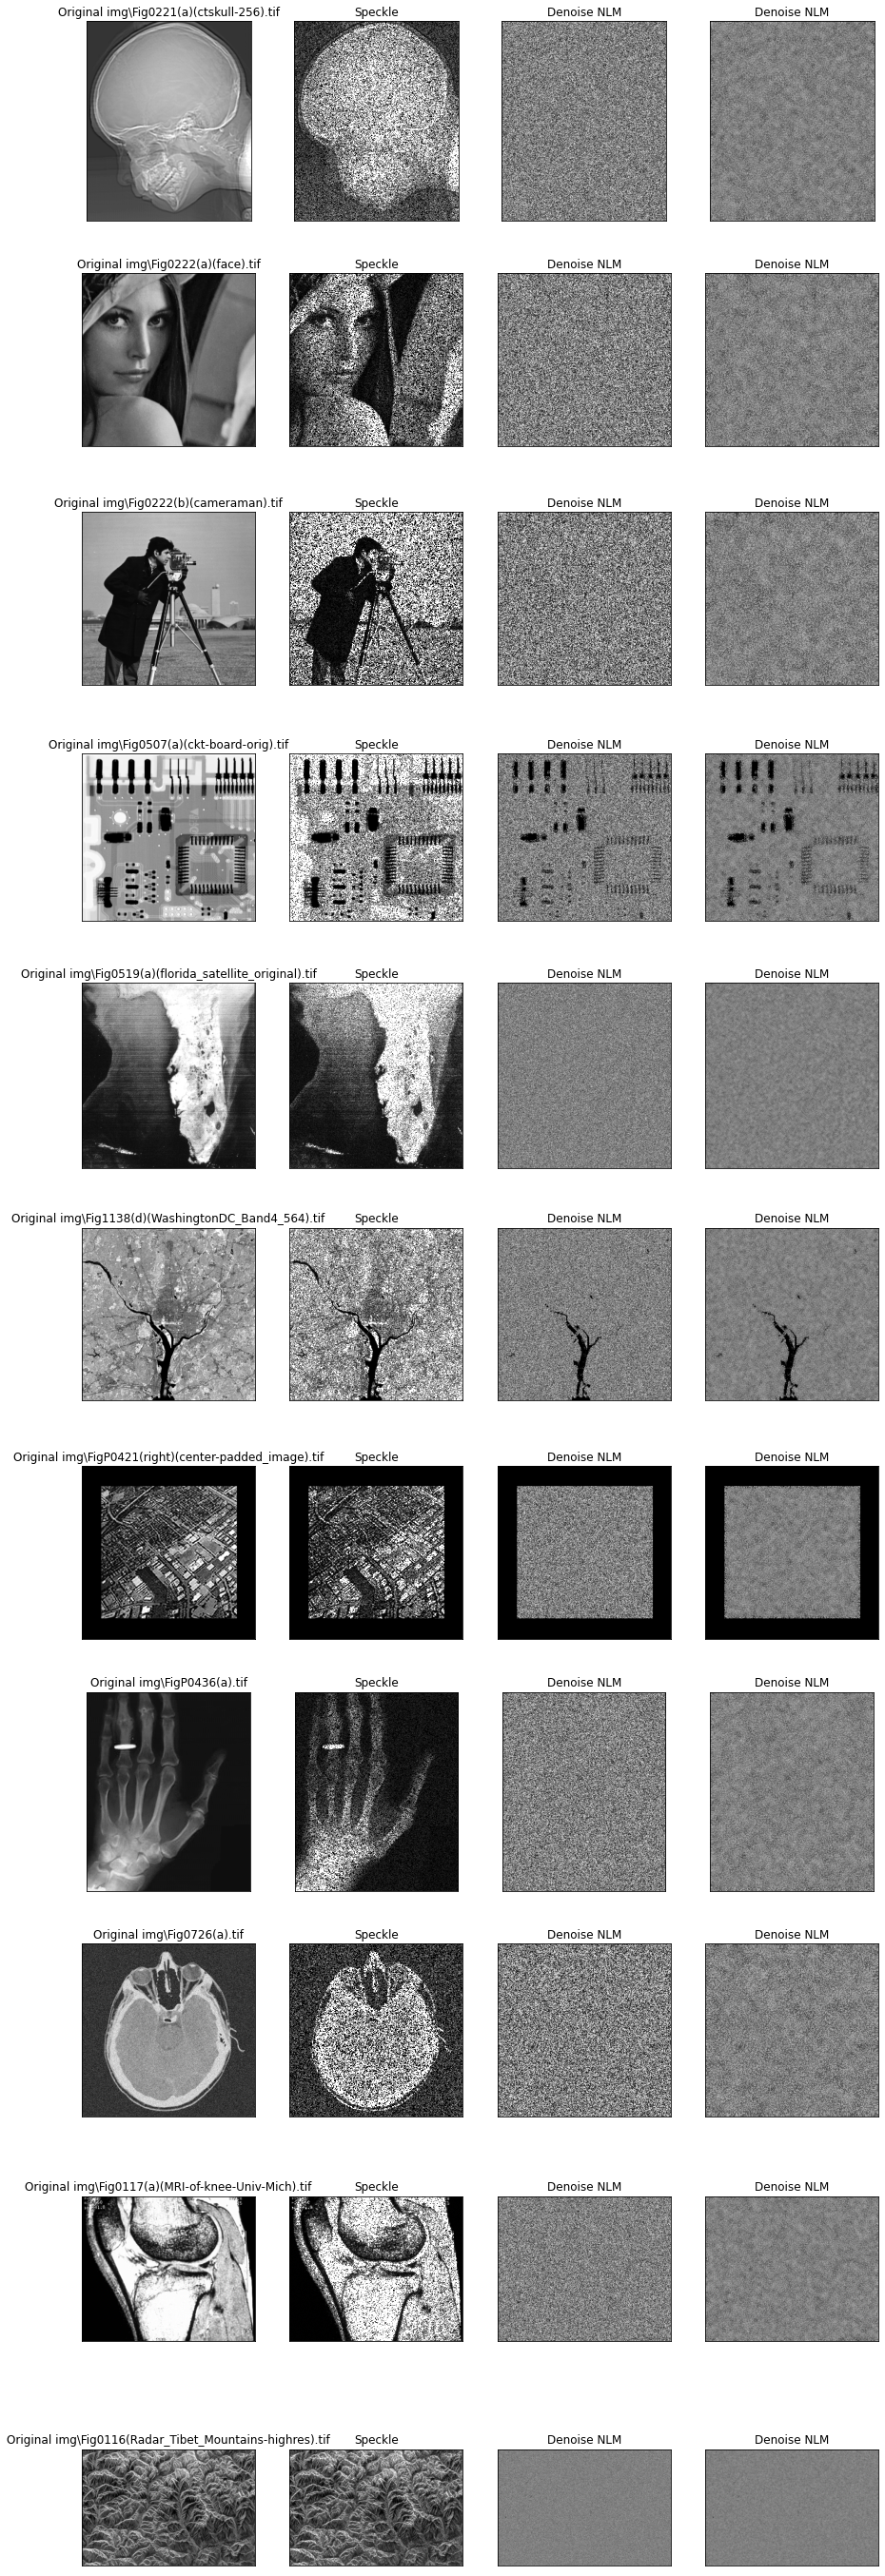

In [24]:
import imp
import numpy as np
import matplotlib.pyplot as plt
import cv2
import noise
imp.reload(noise)
denoise_types = [noise.DENOISE_TYPE_NLM, noise.DENOISE_TYPE_FROST]
fig, axs = plt.subplots(len(img_cases), len(denoise_types)+2 , figsize=(15,50), sharex=False, sharey=False)
for i,img_case in  enumerate(img_cases) :
    img_case = os.path.join(img_dir, img_case)
    img = cv2.imread(img_case, cv2.IMREAD_GRAYSCALE)
    img_noise = noise.noisify(noise.NOISE_TYPE_SPECKLE, img)
    set_subplot_settings(img, axs[i,0], f'Original {img_case}')
    set_subplot_settings(img_noise, axs[i,1],f'Speckle')

    for j,filter in enumerate(denoise_types):
        img_denoise = noise.denosify(filter,img_noise)
        set_subplot_settings(img_denoise, axs[i,j+2],f'Denoise NLM')
plt.show()    